In [1]:
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import optimize
%pylab inline 
import statsmodels.formula.api as smf
import community as cmnt
import json
import geopandas as gpd
import shapefile as sf

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Reading rides data for June, 2014 and stations location
allrides = pd.read_csv('2014-06 - Citi Bike trip data.csv')
stations = pd.read_csv( 'citibike-locations.csv')

In [3]:
# stations.head()

In [4]:
# Converting starttime, stoptime into datetime format
allrides['starttime'] = pd.to_datetime(allrides['starttime'])
allrides['stoptime']  = pd.to_datetime(allrides['stoptime'])

# Calculating ride duration
allrides['duration'] = allrides['stoptime'] - allrides['starttime']
allrides['duration'] = pd.to_datetime(allrides['duration'])
print len(allrides)

936880


In [5]:
allrides.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,duration
0,520,2014-06-01 00:00:02,2014-06-01 00:08:42,358,Christopher St & Greenwich St,40.732916,-74.007114,426,West St & Chambers St,40.717548,-74.013221,18840,Subscriber,1979,1,1970-01-01 00:08:40
1,520,2014-06-01 00:00:27,2014-06-01 00:09:07,335,Washington Pl & Broadway,40.729039,-73.994046,265,Stanton St & Chrystie St,40.722293,-73.991475,17442,Customer,\N,0,1970-01-01 00:08:40
2,414,2014-06-01 00:00:32,2014-06-01 00:07:26,439,E 4 St & 2 Ave,40.726281,-73.989780,368,Carmine St & 6 Ave,40.730386,-74.002150,16447,Subscriber,1980,1,1970-01-01 00:06:54
3,310,2014-06-01 00:00:34,2014-06-01 00:05:44,463,9 Ave & W 16 St,40.742065,-74.004432,380,W 4 St & 7 Ave S,40.734011,-74.002939,18218,Subscriber,1984,1,1970-01-01 00:05:10
4,457,2014-06-01 00:00:35,2014-06-01 00:08:12,352,W 56 St & 6 Ave,40.763406,-73.977225,305,E 58 St & 3 Ave,40.760958,-73.967245,18115,Subscriber,1969,1,1970-01-01 00:07:37


In [6]:
stations_name = allrides.groupby(['start station id', 'start station name']).count()
stations_name = stations_name.reset_index()

In [7]:
stations_name = stations_name[['start station id', 'start station name', 'tripduration']]
stations_name.columns = ['id', 'name', 'count']
stations_name.head()
print len(stations_name)
print stations_name

328
       id                             name  count
0      72                 W 52 St & 11 Ave   3088
1      79         Franklin St & W Broadway   2357
2      82           St James Pl & Pearl St   1191
3      83    Atlantic Ave & Fort Greene Pl   1270
4     116                  W 17 St & 8 Ave   5168
5     119         Park Ave & St Edwards St    158
6     120      Lexington Ave & Classon Ave    514
7     127            Barrow St & Hudson St   1926
8     128         MacDougal St & Prince St   5097
9     137            E 56 St & Madison Ave   1805
10    143        Clinton St & Joralemon St    950
11    144              Nassau St & Navy St    400
12    146             Hudson St & Reade St   2422
13    147         Greenwich St & Warren St   4963
14    150                E 2 St & Avenue C   1885
15    151         Cleveland Pl & Spring St   7145
16    152            Warren St & Church St   1848
17    153                  E 40 St & 5 Ave   3533
18    157          Henry St & Atlantic Ave   1

In [8]:
station_name = allrides.groupby(['end station id', 'end station name']).count()
station_name = station_name.reset_index()

In [9]:
station_name = station_name[['end station id', 'end station name', 'tripduration']]
station_name.columns = ['id', 'name', 'count']
station_name.head()
print len(station_name)
print station_name

328
       id                             name  count
0      72                 W 52 St & 11 Ave   3156
1      79         Franklin St & W Broadway   2483
2      82           St James Pl & Pearl St   1196
3      83    Atlantic Ave & Fort Greene Pl   1584
4     116                  W 17 St & 8 Ave   5156
5     119         Park Ave & St Edwards St    156
6     120      Lexington Ave & Classon Ave    493
7     127            Barrow St & Hudson St   1970
8     128         MacDougal St & Prince St   5099
9     137            E 56 St & Madison Ave   2147
10    143        Clinton St & Joralemon St   1030
11    144              Nassau St & Navy St    426
12    146             Hudson St & Reade St   2411
13    147         Greenwich St & Warren St   4939
14    150                E 2 St & Avenue C   1867
15    151         Cleveland Pl & Spring St   7204
16    152            Warren St & Church St   1917
17    153                  E 40 St & 5 Ave   3736
18    157          Henry St & Atlantic Ave   1

In [10]:
len(allrides)

936880

In [11]:
# Reading descriptive statistics
allrides['tripduration'].describe()

count    936880.000000
mean        892.240022
std         919.055773
min          60.000000
25%         417.000000
50%         673.000000
75%        1112.000000
max       21576.000000
Name: tripduration, dtype: float64

In [12]:
# # Cleaning the data, removing lower 25%, longer than 7 minutes
# allrides = allrides[allrides['duration'] > '1970-01-01 00:07:00']
# print len(allrides)

In [13]:
# # function to calculate if a given date is a weekday, or a weekend
# def Weekend(x):
#     if x.weekday() > 4:
#         return True
#     return False

# # checking if a start time of the trip is a weekend
# allrides['weekEnd'] = allrides['starttime'].apply(lambda x: Weekend(x))
# allrides.head()

In [14]:
# Splitting the data into weekday and weekend datasets
subcriber = allrides[allrides['usertype'] == 'Subscriber']
customer = allrides[allrides['usertype'] == 'Customer']
print len(subcriber)
print len(customer)

818675
118205


In [15]:
# Counting rides between each pair of the stations
subcriber_grouped = subcriber.groupby(['start station id', 'end station id']).count()
customer_grouped = customer.groupby(['start station id', 'end station id']).count()

In [16]:
# Resetting the indeces
subcriber_grouped = subcriber_grouped.reset_index()
customer_grouped = customer_grouped.reset_index()

In [17]:
# Selecting 3 columns, representing node A, node B and weight of the edges
customer_grouped = customer_grouped[['start station id', 'end station id', 'tripduration']]
subcriber_grouped = subcriber_grouped[['start station id', 'end station id', 'tripduration']]
customer_grouped.columns = ['start', 'stop', 'weight']
subcriber_grouped.columns = ['start', 'stop', 'weight']

In [18]:
# Taking a look at the resulting dataframes
print customer_grouped.head()
print subcriber_grouped.head()

   start  stop  weight
0     72    72      33
1     72    79       2
2     72   116       1
3     72   137       1
4     72   147       1
   start  stop  weight
0     72    72      68
1     72    79       8
2     72    82       2
3     72    83       1
4     72   116       4


In [19]:
# Creating the graphs
customer_graph = nx.DiGraph()
subscriber_graph = nx.DiGraph()

# There are 9 weekends and 21 weekday in June, 2014
# Adding edges
for k in customer_grouped.index:
    customer_graph.add_edge(customer_grouped['start'][k], 
                            customer_grouped['stop'][k], 
                            weight = 1.0*customer_grouped['weight'][k]/30)
for k in subcriber_grouped.index:
    subscriber_graph.add_edge(subcriber_grouped['start'][k], 
                              subcriber_grouped['stop'][k], 
                              weight = 1.0*subcriber_grouped['weight'][k]/30)

In [20]:
#output top tn centrality scores, given the dictionary d
def topdict(d,tn):
    ind=sorted(d, key=d.get, reverse=True)
    for i in range(0,tn):
       print('{0}|{1}:{2} {3}'.format(i+1,
                                      ind[i],
                                      d[ind[i]], 
                                      stations_name[stations_name['id']==ind[i]]['name'].values[0]))
#              #, stations_name.name[stations_name.id == ind[i]][1]))

In [21]:
# Pagerank for various alphas
#alpha = [0.95, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#for al in alpha:
print "Subscriber as a whole"
topdict(nx.pagerank(subscriber_graph, 0.85), 10)
print "Customer as a whole"
topdict(nx.pagerank(customer_graph, 0.85), 10)
#print "\n"

Subscriber as a whole
1|293:0.00907538354057 Lafayette St & E 8 St
2|497:0.0090744822856 E 17 St & Broadway
3|521:0.0086085217247 8 Ave & W 31 St
4|358:0.00780553923577 Christopher St & Greenwich St
5|435:0.00772149529016 W 21 St & 6 Ave
6|519:0.00749460096084 E 42 St & Vanderbilt Ave
7|426:0.00716480217719 West St & Chambers St
8|382:0.00702298767529 University Pl & E 14 St
9|151:0.00695284312926 Cleveland Pl & Spring St
10|285:0.00660183528664 Broadway & E 14 St
Customer as a whole
1|387:0.0198017261073 Centre St & Chambers St
2|2006:0.0185092214539 Central Park S & 6 Ave
3|426:0.0151066158959 West St & Chambers St
4|281:0.0128201488563 Grand Army Plaza & Central Park S
5|499:0.0117372535981 Broadway & W 60 St
6|514:0.0109822080692 12 Ave & W 40 St
7|532:0.0097503331045 S 5 Pl & S 4 St
8|327:0.00961417313833 Vesey Pl & River Terrace
9|2002:0.00883764577571 Wythe Ave & Metropolitan Ave
10|457:0.00824311047254 Broadway & W 58 St


In [22]:
# Function that removes loops from the graph
def remove_loops(G):
    GU=G
    for n in GU.nodes():
        if GU.has_edge(n,n):
            GU.remove_edge(n,n)
    return GU  

In [23]:
# Function that creates undirected symmetrical graph
def directed_to_undirected(G):
    GU=nx.Graph()
    for e in G.edges(data=True):
        if GU.has_edge(e[0],e[1]):
            GU[e[0]][e[1]]['weight']=GU[e[0]][e[1]]['weight']+e[2]['weight']
        else:
            GU.add_edge(e[0],e[1],weight=e[2]['weight'])
    return GU   

In [24]:
subscriber_graph = remove_loops(subscriber_graph)
customer_graph = remove_loops(customer_graph)

subscriber_graph = directed_to_undirected(subscriber_graph)
customer_graph = directed_to_undirected(customer_graph)

subs_community = cmnt.best_partition(subscriber_graph)
cust_community = cmnt.best_partition(customer_graph)

In [25]:
# Pageranks
subs_pagerank = nx.pagerank(subscriber_graph, 0.85)
cust_pagerank = nx.pagerank(customer_graph, 0.85)

In [26]:
# Calculating locations of the stations
pos ={}
for c in stations.index:
    pos[stations.station_id[c]] = (stations.lon[c], stations.lat[c])

In [50]:
# Visualizing function
def visualizePartition(G, partition, pgrank, pos):
    labels = {}   
    N=len(G.nodes())
    s=4+4*int(log10(N))
    plt.figure(figsize=(s,s))
    PN=max(partition.values())
    my_cmap = matplotlib.cm.hsv(np.linspace(0,1,PN+1)) #create a colormap for a given number of communities
    c=[]
    for n in G.nodes():
        c.append(1.0*partition[n]/PN)
        if 1.5E5*pgrank[n] > 1000:
            #set the node name as the key and the label as its value 
            labels[n] = n
    n_size = 1.5E5*np.array(pgrank.values())
    for i in range(0, len(n_size)):
        if n_size[i] <1000:
            n_size[i] = 100
            
    nx.draw(G, pos=pos, with_labels=False, arrows=True, node_size=n_size, 
            node_color=c, width=0.5, style='dotted',edge_color='green')
#     nx.draw_networkx_labels(G,pos,labels)
#     print(1.5E5*np.array(pgrank.values()))
#     mplleaflet.display()

In [29]:
# weights = sorted(weights)
# weights = np.array(weights)
# print(weights.mean())
# print(weights.std())

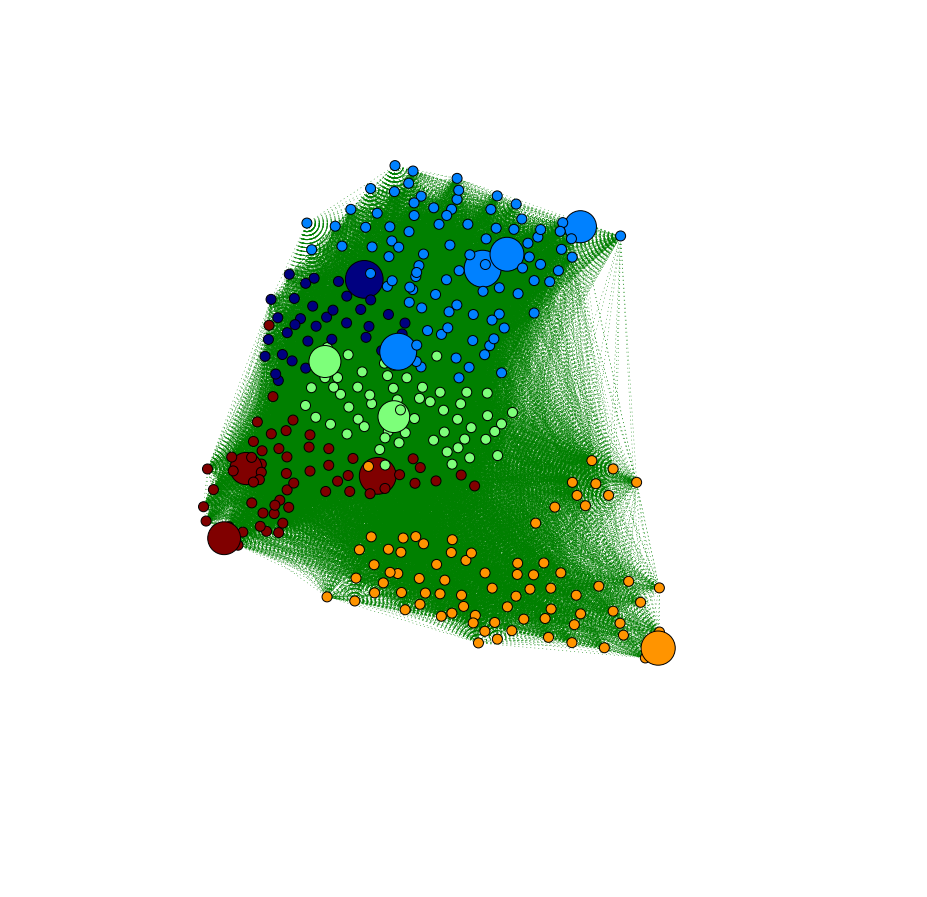

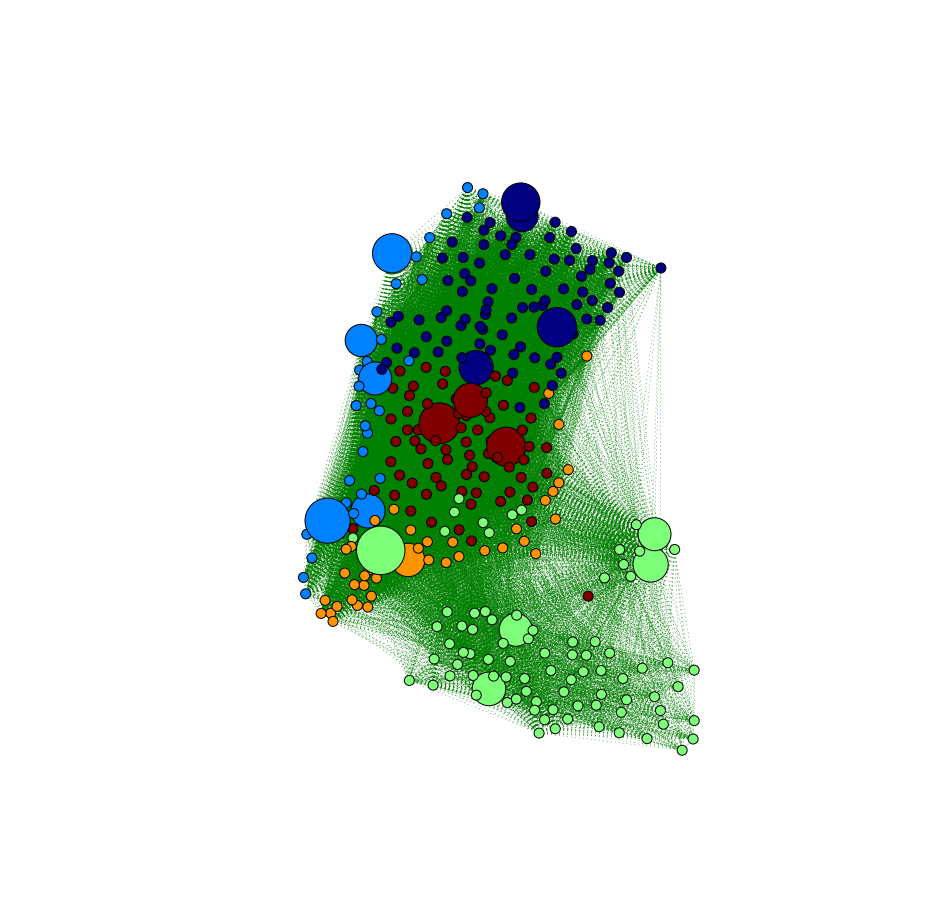

In [49]:
# Plotting the communities
random.seed(2015)
visualizePartition(subscriber_graph, subs_community, subs_pagerank, pos)
random.seed(2015)
visualizePartition(customer_graph, cust_community, cust_pagerank, pos)

In [32]:
print np.unique(subs_community.values())

[0 1 2 3 4]


In [33]:
# Splitting the graphs into communities for weekday
group0 = []
group1 = []
group2 = []
group3 = []
group4 = []
for k in subs_community:
    if subs_community[k] == 0:
        group0.append(k)
    if subs_community[k] == 1:
        group1.append(k)
    if subs_community[k] == 2:
        group2.append(k)
    if subs_community[k] == 3:
        group3.append(k)
    if subs_community[k] == 4:
        group4.append(k)

subs_graph0 = subscriber_graph.subgraph(group0)
subs_graph1 = subscriber_graph.subgraph(group1)
subs_graph2 = subscriber_graph.subgraph(group2)
subs_graph3 = subscriber_graph.subgraph(group3)
subs_graph4 = subscriber_graph.subgraph(group4)

In [34]:
# Splitting the graphs into communities for weekday
group0 = []
group1 = []
group2 = []
group3 = []
group4 = []
for k in cust_community:
    if cust_community[k] == 0:
        group0.append(k)
    if cust_community[k] == 1:
        group1.append(k)
    if cust_community[k] == 2:
        group2.append(k)
    if cust_community[k] == 3:
        group3.append(k)
    if cust_community[k] == 4:
        group4.append(k)

cust_graph0 = customer_graph.subgraph(group0)
cust_graph1 = customer_graph.subgraph(group1)
cust_graph2 = customer_graph.subgraph(group2)
cust_graph3 = customer_graph.subgraph(group3)
cust_graph4 = customer_graph.subgraph(group4)

In [35]:
#output top tn centrality scores, given the dictionary d
def topdict2(d,tn):
    sub = []
    ind=sorted(d, key=d.get, reverse=True)
    for i in range(0,tn):
        sub.append(ind[i])
    return sub

[281, 2006, 499, 457, 444, 173, 352, 519, 521, 493]
[352, 519, 457, 173, 493, 499, 2006, 521, 281, 444]


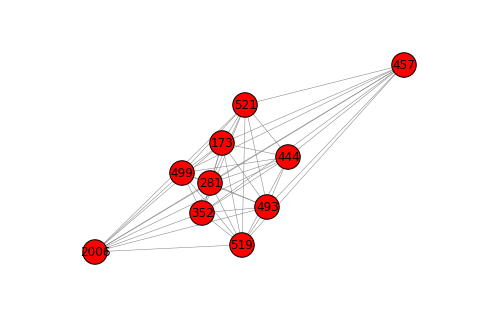

In [36]:
cust0_top = topdict2(nx.pagerank(cust_graph0, 0.85), 10)
print cust0_top
cust_gr0 = cust_graph0.subgraph(cust0_top)
print cust_gr0.nodes()
random.seed(2015)
nx.draw(cust_gr0, with_labels=True, arrows=True, node_color='red', width=0.5, edge_color='gray', node_size = 0.6e3)

In [37]:
# Calculating pageranks for each community inside each community
print "Customer community 0"
topdict(nx.pagerank(cust_graph0, 0.85), 10)
print "\n"
print "Subscriber community 0"
topdict(nx.pagerank(subs_graph0, 0.85), 10)
print "\n\n"

print "Customer community 1"
topdict(nx.pagerank(cust_graph1, 0.85), 10)
print "\n"
print "Subscriber community 1"
topdict(nx.pagerank(subs_graph1, 0.85), 10)
print "\n\n"

print "Customer community 2"
topdict(nx.pagerank(cust_graph2, 0.85), 10)
print "\n"
print "Subscriber community 2"
topdict(nx.pagerank(subs_graph2, 0.85), 10)
print "\n\n"

print "Customer community 3"
topdict(nx.pagerank(cust_graph3, 0.85), 10)
print "\n"
print "Subscriber community 3"
topdict(nx.pagerank(subs_graph3, 0.85), 10)
print "\n\n"

print "Customer community 4"
topdict(nx.pagerank(cust_graph4, 0.85), 10)
print "\n"
print "Subscriber community 4"
topdict(nx.pagerank(subs_graph4, 0.85), 10)
print "\n\n"


Customer community 0
1|281:0.0557962401808 Grand Army Plaza & Central Park S
2|2006:0.0521693378917 Central Park S & 6 Ave
3|499:0.0413117985301 Broadway & W 60 St
4|457:0.029651233235 Broadway & W 58 St
5|444:0.0227368434481 Broadway & W 24 St
6|173:0.019023479111 Broadway & W 49 St
7|352:0.0173747632108 W 56 St & 6 Ave
8|519:0.0170650171383 E 42 St & Vanderbilt Ave
9|521:0.0163524825818 8 Ave & W 31 St
10|493:0.0159913890987 W 45 St & 6 Ave


Subscriber community 0
1|521:0.0607861069546 8 Ave & W 31 St
2|435:0.0491029550889 W 21 St & 6 Ave
3|284:0.0414907495157 Greenwich Ave & 8 Ave
4|462:0.0411687771568 W 22 St & 10 Ave
5|509:0.0389572633833 9 Ave & W 22 St
6|358:0.0383416150208 Christopher St & Greenwich St
7|446:0.0365003960029 W 24 St & 7 Ave
8|116:0.0364816852648 W 17 St & 8 Ave
9|453:0.0330557116191 W 22 St & 8 Ave
10|459:0.0326107458575 W 20 St & 11 Ave



Customer community 1
1|426:0.0920544409236 West St & Chambers St
2|514:0.0685668421617 12 Ave & W 40 St
3|327:0.0593421152

In [38]:
nycsh = json.load(open('nyc-zip-code-tabulation-areas-polygons.geojson'))

In [39]:
import matplotlib.patches as mpatches
from descartes import PolygonPatch

(-74.299999999999997,
 -73.599999999999994,
 40.400000000000006,
 41.000000000000007)

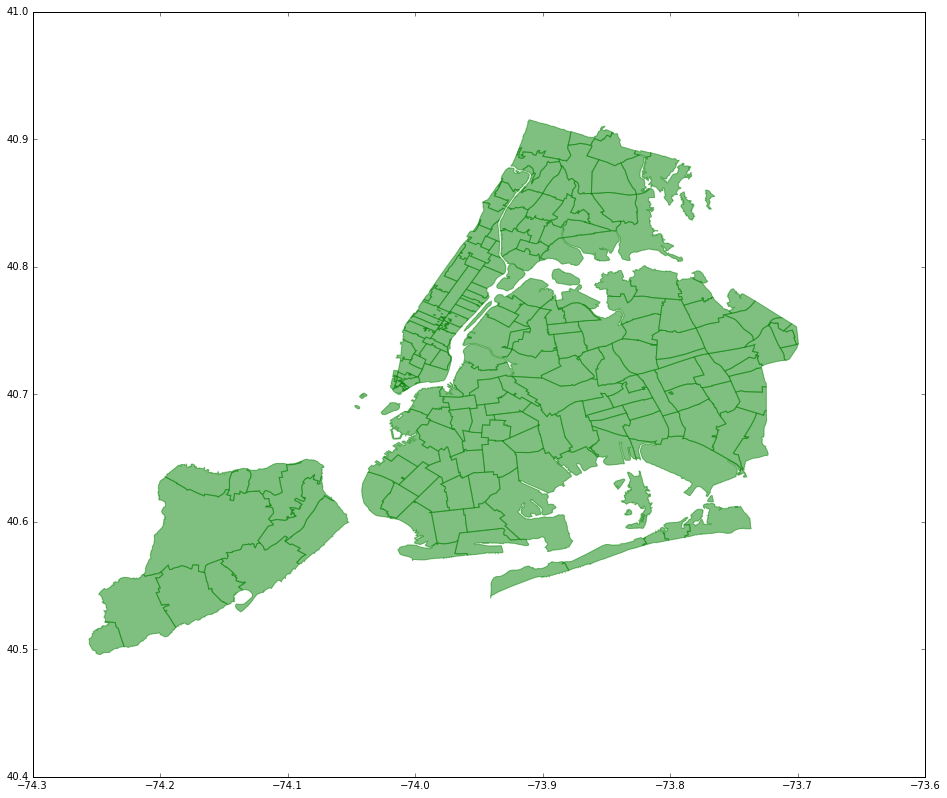

In [40]:
fig = plt.figure(figsize=(16,16)) 
for i in nycsh['features']:
    poly = i['geometry']
    ax = fig.gca()
    ax.add_patch(PolygonPatch(poly, fc='green', ec='green', alpha=0.5, zorder=2 ))
#     print(poly)
#     ax.plot(-73.86942457284175, 40.74915687096787, c='r')
#     ax.plot(40.74915687096787, -73.86942457284175, c='r')
ax.axis('scaled')

In [41]:
allrides.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender', u'duration'],
      dtype='object')

In [43]:
# import mplleaflet
# fig = plt.figure(figsize=(16,16))
# ax = fig.add_subplot(111)
# # ax.set_axis_bgcolor(backgroundco
# ax.scatter(x=stations['lon'], y=stations['lat'], c='m', alpha=0.4, s=100)
# ax.plot(allrides[''])
# mplleaflet.display()

In [ ]:
from pysal.contrib.viz import mapping as map

In [ ]:
rwy_tun=gpd.read_file('locations/locations.shp')

In [ ]:
rwy_tun = rwy_tun.set_index('station_id')
rwy_tun.info()

In [ ]:
from shapely.geometry import Point

In [ ]:
# stations[['lat','lon']].to_dict()